# Name and ID: Hoang Tu Bui - 24005665

# The code executes till the end without any errors

# Original source: 

1. https://medium.com/@liyinxuan0213/step-by-step-double-deep-q-networks-double-dqn-tutorial-from-atari-games-to-bioengineering-dec7e6373896
1. https://stackoverflow.com/questions/26587527/cite-a-paper-using-github-markdown-syntax

# Why Reinforcement Learning is the ML paradigm of choice for this task?

Reinforcement Learning (RL) is well-suited for Atari games like Breakout where an agent must learn to make decisions through trial and error, optimizing its actions based on feedback in the form of rewards. This paradigm is distinct from supervised learning, which relies on pre-labeled data, and unsupervised learning, which seeks to find patterns without any labeled responses ([Shaheen et al., 2025](#shaheen2025reinforcementlearningstrategybasedatari)).

In Breakout, the agent must learn to control a paddle to bounce a ball and break bricks, receiving rewards only when bricks are broken. This setup presents a challenge where the agent must learn the consequences of its actions over time, making RL an ideal approach . ​

The success of RL in Breakout not only showcases its effectiveness in gaming but also highlights its potential in real-world applications where decision-making under uncertainty and learning from interaction are crucial.​

In summary, RL's framework aligns seamlessly with the challenges presented by Breakout, making it the machine learning paradigm of choice for such tasks.​

# The Environment

1. The game selected: **Breakout**

    The goal is to control a paddle in order to hit a ball toward brick walls at the top of the screen and to break them ([AtariAge - Atari 2600 Manuals (HTML) - Breakout (Atari), 1997-1998](#breakout-description)). The player starts with 5 lives and loses a life if the ball drops. The game terminates and resets when all lives are lost.

1. The input from the environment: A 210x160 RGB image frame from the game screen, where each pixel value is an unsigned 8-bit integer ranging from 0 to 255 ([Implementation/Game environment](#game-environment)).

1. The control settings: four Discrete actions ([Machado et al., 2018](#ale-breakout-doc)):
    - 0:NOOP (No Operation)
    - 1:FIRE
    - 2:RIGHT
    - 3:LEFT

# Implementation

## Game environment

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


Action space: Discrete(4)
Observation space: Box(0, 255, (210, 160, 3), uint8)


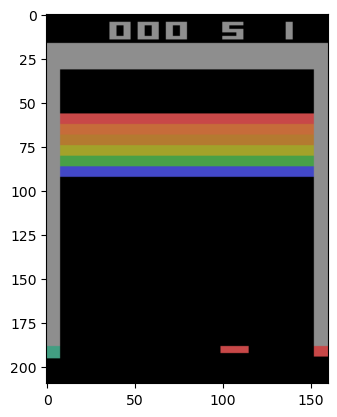

In [1]:
import ale_py
import gymnasium as gym
import matplotlib.pyplot as plt


gym.register_envs(ale_py)
org_env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

print(f"Action space: {org_env.action_space}")
print(f"Observation space: {org_env.observation_space}")

org_env.reset()
rgb_arr = org_env.render()

assert rgb_arr is not None, "Rendering empty array"
plt.imshow(rgb_arr)
plt.show()

I noticed that the observation includes redundant information — specifically, the scoreboard at the top, which takes up 20 pixels. Thus they will be cut of using Gymnasium Wrappers. Finally, a Normalize wrapper scales pixel value from [0,255] to [0,1].

Other modifications to the onservations include:

1. RecordEpisodeStatistics: keeps track of cumulative rewards and episode lengths.
1. ResizeObservation((84, 84)): ensures the input to be in fixed size and reduce computation
1. GrayscaleObservation: reduces input dimensionality from 3 channels to 1 while preserving essential information
1. FrameStackObservation(4): Stacks the last 4 grayscale frames together to provide temporal context
1. MaxAndSkipObservation(skip=4): reduces computation and removes flickering artifacts 

In [2]:
from gymnasium.spaces import Box
from stable_baselines3.common.atari_wrappers import MaxAndSkipEnv


env = gym.wrappers.RecordEpisodeStatistics(org_env)

# Cut 20 pixels from the top
org_obs_space = env.observation_space
assert isinstance(org_obs_space, Box), "Observation space is not a Box"
env = gym.wrappers.TransformObservation(
    env,
    lambda obs: obs[20:, :, :],
    observation_space=Box(
        low=org_obs_space.low[20:, :, :],
        high=org_obs_space.high[20:, :, :],
        dtype=org_obs_space.dtype,  # type: ignore
    ),
)

# Resize from 210x160 to 84x84
env = gym.wrappers.ResizeObservation(env, (84, 84))
# Convert rgb to grayscale
env = gym.wrappers.GrayscaleObservation(env)
# Stack 4 frames for temporal information
env = gym.wrappers.FrameStackObservation(env, 4)
# Only change action every 4th frame
env = MaxAndSkipEnv(env, skip=4)
# Scale pixels to [0, 1]
env = gym.wrappers.TransformObservation(
    env,
    lambda obs: obs / 255.0,
    observation_space=Box(
        low=0.0,
        high=1.0,
        shape=env.observation_space.shape,
        dtype=env.observation_space.dtype,  # type: ignore
    ),
)

### Observation from the environment

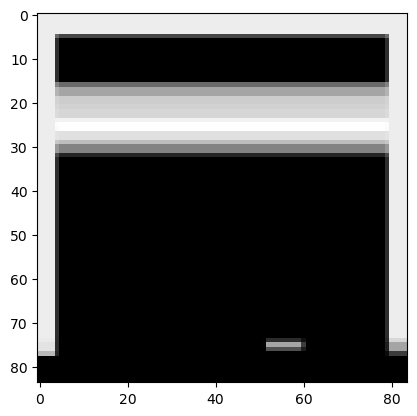

In [3]:
obs, _ = env.reset()

plt.imshow(obs.squeeze()[0], cmap="gray")
plt.show()

## VANILLA DQN

In [4]:
from torch import nn


class DQN(nn.Module):
    def __init__(self, n_actions):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(512, n_actions),
        )

    def forward(self, x):
        return self.network(x.float())

In [5]:
import copy
from gymnasium import Env
from stable_baselines3.common.buffers import ReplayBuffer
import torch
from torch.optim.adam import Adam
import torch.nn.functional as F
from pathlib import Path
import random
import numpy as np


def DQN_train(
    env: Env,
    model: nn.Module,
    device="cuda",
    buffer_size=10_000,
    n_epochs=30_000,
    train_feq=4,
    batch_size=96,
    gamma=0.99,
    replay_start_size=50,
    epsilon_start=1,
    epsilon_end=0.1,
    exploration_steps=1_000,
    C=10,  # Target network update frequency
    learning_rate=1.25e-4,
    verbose=False,
):

    # Initialize replay memory D to capacity N
    rb = ReplayBuffer(
        buffer_size,
        env.observation_space,
        env.action_space,
        device,
        optimize_memory_usage=True,
        handle_timeout_termination=False,
    )

    # action-value function Q
    onlineNetwork = model.to(device)
    # target action-value function Q_hat
    target_network = copy.deepcopy(onlineNetwork).to(device)

    optimizer = Adam(onlineNetwork.parameters(), lr=learning_rate)

    smoothed_rewards = []
    rewards = []
    loss_means = []
    losses = []
    best_reward = float("-inf")
    best_model_state = {}

    checkpoints = Path("checkpoint_graphs")
    checkpoints.mkdir(parents=True, exist_ok=True)

    epoch = 0
    while epoch < n_epochs:
        dead = False
        total_rewards = 0

        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        obs, _ = env.reset()

        for _ in range(random.randint(1, 30)):  # random actions to reset environment
            obs, *_, info = env.step(1)  # random.randint(0, 3))

        while not dead:
            current_life = info["lives"]

            epsilon = max(
                (
                    (epsilon_end - epsilon_start) / exploration_steps * epoch
                    + epsilon_start
                ),
                epsilon_end,
            )

            # With probability ε select a random action a
            if random.random() < epsilon:
                action = np.array(env.action_space.sample())
            # Otherwise select a = max_a Q∗(φ(st), a; θ)
            else:
                q_values = onlineNetwork(torch.Tensor(obs).unsqueeze(0).to(device))
                action = np.array(torch.argmax(q_values, dim=1).item())

            # Execute action a in emulator and observe reward rt and image xt+1
            next_obs, reward, terminated, truncated, info = env.step(action)
            dead = terminated or truncated

            reward = float(reward)

            # action leads to a life lost
            lostLife = np.array(info["lives"] < current_life)
            # if lostLife:
            #     reward -= 1
            # else:
            #     firstFr = next_obs[0]
            #     if np.all(next_obs == firstFr):
            #         reward -= 0.01

            # Set st+1 = st, at, xt+1 and preprocess φt+1 = φ(st+1)
            real_next_obs = next_obs.copy()

            total_rewards += reward
            reward = np.clip(reward, -1, 1)  # Reward clipping

            # Store transition (φt, at, rt, φt+1) in D
            rb.add(obs, real_next_obs, action, reward, lostLife, [info])

            obs = next_obs

            if epoch > replay_start_size and epoch % train_feq == 0:
                # Sample random minibatch of transitions (φj , aj , rj , φj +1 ) from D
                data = rb.sample(batch_size)

                currQ_Vals = onlineNetwork(data.observations).gather(1, data.actions)
                currQ_Val = currQ_Vals.squeeze()

                with torch.no_grad():
                    maxQ_Val, _ = target_network(data.next_observations).max(dim=1)
                    y = data.rewards.flatten() + (
                        gamma * maxQ_Val * (1 - data.dones.flatten())
                    )

                loss = F.huber_loss(y, currQ_Val)

                # Perform a gradient descent step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                losses.append(loss.item())

                if verbose:
                    print(
                        f"Epoch: {epoch}, Epsilon: {epsilon:.4f}, Loss: {loss.item():.4f}, "
                        f"Reward: {total_rewards:.2f}, Action: {action}"
                    )

            # Every C steps reset Q_hat=Q
            if epoch % C == 0:
                target_network.load_state_dict(onlineNetwork.state_dict())

            epoch += 1

            # Average reward and loss
            smoothInterval = 100
            if (epoch % smoothInterval == 0) and epoch > 0:
                smoothed_reward = np.mean(rewards[-smoothInterval:])
                smoothed_rewards.append(smoothed_reward)

                loss_mean = np.mean(losses[-smoothInterval:])
                loss_means.append(loss_mean)

        rewards.append(total_rewards)

        if total_rewards > best_reward:
            best_reward = total_rewards

            best_model_state = copy.deepcopy(onlineNetwork.state_dict())

    # target_network.load_state_dict(best_model_state)

    return (
        target_network,
        smoothed_rewards,
        loss_means,
    )

In [6]:
model = DQN(env.action_space.n)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model, smoothed_rewards, loss_means, *_ = DQN_train(
    # env,
    # model,
    # device=device,
    # verbose=True,
    # buffer_size=10_000,
    # n_epochs=300_000,
    # batch_size=32,
    # gamma=0.99,
    # replay_start_size=500,
    # epsilon_start=1,
    # epsilon_end=0.1,
    # exploration_steps=100_000,
    # C=100,
    # learning_rate=1.25e-4,
    ####################Quick test#############################
    env,
    model,
    device=device,
    verbose=True,
    buffer_size=10_000,
    n_epochs=30_000,
    batch_size=32,
    gamma=0.99,
    replay_start_size=500,
    epsilon_start=1,
    epsilon_end=0.1,
    exploration_steps=10_000,
    C=10,
    learning_rate=1.25e-4,
)

Using device: cuda


/home/tu/micromamba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tu/micromamba/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Epoch: 504, Epsilon: 0.9546, Loss: 0.0008, Reward: 1.00, Action: 2
Epoch: 508, Epsilon: 0.9543, Loss: 0.0339, Reward: 0.00, Action: 3
Epoch: 512, Epsilon: 0.9539, Loss: 0.0001, Reward: 0.00, Action: 2
Epoch: 516, Epsilon: 0.9536, Loss: 0.0001, Reward: 0.00, Action: 2
Epoch: 520, Epsilon: 0.9532, Loss: 0.0001, Reward: 0.00, Action: 1
Epoch: 524, Epsilon: 0.9528, Loss: 0.0158, Reward: 0.00, Action: 1
Epoch: 528, Epsilon: 0.9525, Loss: 0.0326, Reward: 0.00, Action: 2
Epoch: 532, Epsilon: 0.9521, Loss: 0.0477, Reward: 0.00, Action: 2
Epoch: 536, Epsilon: 0.9518, Loss: 0.0480, Reward: 1.00, Action: 1
Epoch: 540, Epsilon: 0.9514, Loss: 0.0001, Reward: 1.00, Action: 1
Epoch: 544, Epsilon: 0.9510, Loss: 0.0163, Reward: 1.00, Action: 1
Epoch: 548, Epsilon: 0.9507, Loss: 0.0004, Reward: 1.00, Action: 3
Epoch: 552, Epsilon: 0.9503, Loss: 0.0003, Reward: 1.00, Action: 0
Epoch: 556, Epsilon: 0.9500, Loss: 0.0007, Reward: 1.00, Action: 1
Epoch: 560, Epsilon: 0.9496, Loss: 0.0159, Reward: 0.00, Actio

### Evaluation

In [15]:
def evaluation(model, env: Env, device, n_episodes, render=0):
    model.to(device)
    model.eval()

    frames = []
    for _ in range(n_episodes):
        obs, info = env.reset()
        dead = False

        step = 0
        terminated = False
        truncated = False
        currLife = info["lives"]
        while not dead:

            if step < render:
                frames.append(env.render())

            with torch.no_grad():
                obs_tensor = torch.tensor(obs).unsqueeze(0).to(device)

                q_values = model(obs_tensor)
                action = np.array(torch.argmax(q_values, dim=1).item())

            if step == 0 or (info["lives"] < currLife) or terminated or truncated:
                # start with fire option
                action = 1
                currLife = info["lives"]

            obs, _, terminated, truncated, info = env.step(action)

            dead = terminated or truncated
            step += 1

    return frames

In [ ]:
from matplotlib import animation
from IPython.display import HTML


frames = evaluation(model, env, device, n_episodes=1, render=1000)

# Limit to 1000 frames for display
frames = [frames[i] for i in range(min(len(frames), 1000))]

print(f"Drawing {len(frames)} frames")
fig = plt.figure()
plt.axis("off")
im = plt.imshow(frames[0])


def update_frame(frame):
    im.set_data(frame)
    return [im]


ani = animation.FuncAnimation(fig, update_frame, frames=frames, interval=50)
plt.close(fig)
HTML(ani.to_jshtml())

## DOUBLE DQN

# Test ref 
"...the **go to** statement should be abolished..." ([Dijkstra, 1968](#1)).




# References

1. <a id="1"></a> 
Dijkstra, E. W. (1968). 
Go to statement considered harmful. 
Communications of the ACM, 11(3), 147-148.

1. <a id="breakout-description"></a>
AtariAge—Atari 2600 Manuals (HTML)—Breakout (Atari). (1997-1998). Retrieved May 5, 2025, from https://atariage.com/manual_html_page.php?SoftwareID=889

1. <a id="ale-breakout-doc"></a>
Machado, M. C., Bellemare, M. G., Talvitie, E., Veness, J., Hausknecht, M. J., & Bowling, M. (2018). Revisiting the Arcade Learning Environment: Evaluation Protocols and Open Problems for General Agents. Journal of Artificial Intelligence Research, 61, 523–562.
https://ale.farama.org/environments/breakout/

1. <a id="shaheen2025reinforcementlearningstrategybasedatari"></a>
Shaheen, A., Badr, A., Abohendy, A., Alsaadawy, H., & Alsayad, N. (2025). Reinforcement Learning in Strategy-Based and Atari Games: A Review of Google DeepMinds Innovations (No. arXiv:2502.10303). arXiv. https://doi.org/10.48550/arXiv.2502.10303